In [8]:
import keras
import tensorflow as tf

def init():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    keras.backend.tensorflow_backend.set_session(session)
init()

In [9]:
nc_in = 3
nc_out = 3
ngf = 32
ndf = 32
use_lsgan = True
λ = 10 if use_lsgan else 100
channel_first=False


loadSize = 143
imageSize = 128
batchSize = 8
lrD = 2e-4
lrG = 2e-4

In [10]:
def minibatch(data, batchsize):
    length = len(data)
    epoch = i = 0
    tmpsize = None    
    while True:
        size = tmpsize if tmpsize else batchsize
        if i+size > length:
            shuffle(data)
            i = 0
            epoch+=1        
        rtn = [read_image(data[j]) for j in range(i,i+size)]
        i+=size
        tmpsize = yield epoch, np.float32(rtn)       

def minibatchAB(dataA, dataB, batchsize):
    batchA=minibatch(dataA, batchsize)
    batchB=minibatch(dataB, batchsize)
    tmpsize = None    
    while True:        
        ep1, A = batchA.send(tmpsize)
        ep2, B = batchB.send(tmpsize)
        tmpsize = yield max(ep1, ep2), A, B

In [2]:
from PIL import Image
import numpy as np
import glob
from random import randint, shuffle

def load_data(file_pattern):
    return glob.glob(file_pattern)

def read_image_full(fn):
    im = Image.open(fn).convert('RGB')
#     im = im.resize( (loadSize, loadSize), Image.BILINEAR )
    arr = np.array(im)/255*2-1
#     w1,w2 = (loadSize-imageSize)//2,(loadSize+imageSize)//2
#     h1,h2 = w1,w2
#    img = arr[h1:h2, w1:w2, :]
#     if randint(0,1):
#         img=img[:,::-1]
    return arr

def read_image(fn):
    im = Image.open(fn).convert('RGB')
    im = im.resize( (loadSize, loadSize), Image.BILINEAR )
    arr = np.array(im)/255*2-1
    w1,w2 = (loadSize-imageSize)//2,(loadSize+imageSize)//2
    h1,h2 = w1,w2
    img = arr[h1:h2, w1:w2, :]
    if randint(0,1):
        img=img[:,::-1]
    if channel_first:        
        img = np.moveaxis(img, 2, 0)
    return img

path_A = 'data/DeepQ-Synth-Hand-02/data/s006/img/*.png'
path_Bs = ['data/DeepQ-Vivepaper/frame/air/*.png', 'data/DeepQ-Vivepaper/frame/book/*.png']
train_A = load_data(path_A)
train_B = load_data(path_Bs[0]) + load_data(path_Bs[1])
shuffle(train_B)

assert len(train_A) and len(train_B)

In [2]:
from IPython.display import display
def showX(X, rows=1):
    assert X.shape[0]%rows == 0
    int_X = ( (X+1)/2*255).clip(0,255).astype('uint8')
    if channel_first:
        int_X = np.moveaxis(int_X.reshape(-1,3,imageSize,imageSize), 1, 3)
    else:
        int_X = int_X.reshape(-1,imageSize,imageSize, 3)
    int_X = int_X.reshape(rows, -1, imageSize, imageSize,3).swapaxes(1,2).reshape(rows*imageSize,-1, 3)
    display(Image.fromarray(int_X))

In [3]:
train_batch = minibatchAB(train_A, train_B, batchSize)

_, A, B = next(train_batch)
showX(A)
showX(B)
del train_batch, A, B

NameError: name 'minibatchAB' is not defined

In [1]:
from keras.preprocessing.image import ImageDataGenerator
ig = ImageDataGenerator(
    rotation_range=55,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=[0.85, 1.1],
    horizontal_flip=True,
    fill_mode='reflect',
    data_format='channels_last'
)
# ig.fit(data_B)


/nfs/nas-5.1/cwtsai/final/.env3/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)
Using TensorFlow backend.


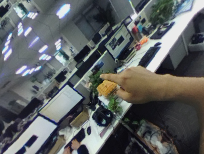

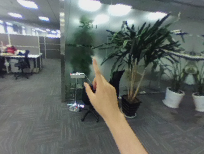

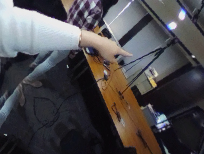

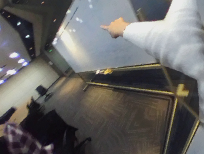

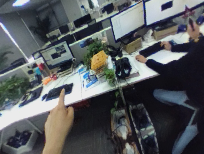

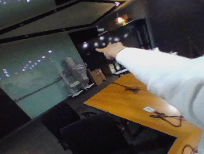

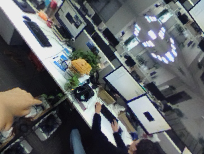

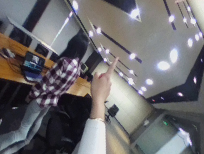

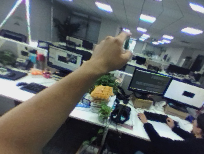

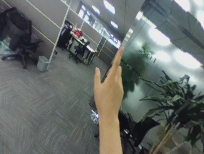

In [4]:
t = 'air'
f = ig.flow(data[:100], np.zeros(100), batch_size=1)

for i in range(10):
    # showX()
    x = next(f)[0]
    int_X = ( (x+1)/2*255).clip(0,255).astype('uint8')
    display(Image.fromarray(int_X[0][::3,::3,:]))

In [5]:
from PIL import Image
import numpy as np
import glob
from random import sample

n_pic = 10000
from tqdm import trange
bs = 16
for t in ['air', 'book']:
    data = np.array([read_image_full(p) for p in sample(glob.glob('data/DeepQ-Vivepaper/frame/%s/*.png' % t), 2000)])
    ig.fit(data)
    cnt = 0
    f = ig.flow(data, np.zeros(len(data)), batch_size=bs)
    for i in trange(n_pic // bs):
        d, _ = next(f)
        for x in d:
            x = ( (x+1)/2*255).clip(0,255).astype('uint8')
            Image.fromarray(x).save('data/DeepQ-Vivepaper/gen3/%s/%05d.png' % (t, cnt))
            cnt = cnt + 1
    del data


  0%|          | 1/625 [00:04<45:55,  4.42s/it]
Exception in thread Thread-4:
Traceback (most recent call last):
  File "/usr/lib/python3.4/threading.py", line 920, in _bootstrap_inner
    self.run()
  File "/nfs/nas-5.1/cwtsai/final/.env3/lib/python3.4/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/nfs/nas-5.1/cwtsai/final/.env3/lib/python3.4/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 625/625 [46:27<00:00,  4.46s/it]


In [7]:
n_layers = 5

In [8]:
from keras.models import Model
from keras.layers import Dense, Conv2D, Flatten, Input

inp = Input((imageSize, imageSize, 3))
x = inp
for l in range(n_layers):
    x = Conv2D(ndf * 2**l, kernel_size=(5, 5), strides=(2, 2), activation='relu', padding='same')(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)
m = Model(inputs=inp, outputs=x)

In [9]:
m.compile(optimizer='rmsprop',
          loss='binary_crossentropy',
          metrics=['accuracy'])

In [ ]:
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        2432      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        51264     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 256)         819456    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 512)         3277312   
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
__________

In [ ]:
import numpy as np
train_batch = minibatchAB(train_A, train_B, batchSize)
bs = batchSize
y0 = np.zeros((batchSize, 1))
y1 = np.ones((batchSize, 1))
y = np.vstack([y0, y1])
at_once = False
for i in range(1000):
    _, A, B = next(train_batch)
    # showX(A)
    # showX(B)
    if at_once:
        x = np.vstack([A, B])
        res = m.train_on_batch(x, y)
        if i % 10==0:
            print(res)
            print(m.predict_on_batch(x)[:2])
            print(m.predict_on_batch(x)[-2:])
    else:
        res = m.train_on_batch(A, y0)
        if i % 10==0:
            print(res)
            print(m.predict_on_batch(A)[:3])
        res = m.train_on_batch(B, y1)
        if i % 10==0:
            print(res)
            print(m.predict_on_batch(B)[:3])
            print()

[0.69609344, 0.375]
[[0.]
 [0.]
 [0.]]
[16.118095, 0.0]
[[0.]
 [0.]
 [0.]]

[1.00000015e-07, 1.0]
[[0.]
 [0.]
 [0.]]
[16.118095, 0.0]
[[0.]
 [0.]
 [0.]]

[1.00000015e-07, 1.0]
[[0.]
 [0.]
 [0.]]
[16.118095, 0.0]
[[0.]
 [0.]
 [0.]]

[1.00000015e-07, 1.0]
[[0.]
 [0.]
 [0.]]
[16.118095, 0.0]
[[0.]
 [0.]
 [0.]]

[1.00000015e-07, 1.0]
[[0.]
 [0.]
 [0.]]
[16.118095, 0.0]
[[0.]
 [0.]
 [0.]]

[1.00000015e-07, 1.0]
[[0.]
 [0.]
 [0.]]
[16.118095, 0.0]
[[0.]
 [0.]
 [0.]]

[1.00000015e-07, 1.0]
[[0.]
 [0.]
 [0.]]
[16.118095, 0.0]
[[0.]
 [0.]
 [0.]]

[1.00000015e-07, 1.0]
[[0.]
 [0.]
 [0.]]
[16.118095, 0.0]
[[0.]
 [0.]
 [0.]]

[1.00000015e-07, 1.0]
[[0.]
 [0.]
 [0.]]
[16.118095, 0.0]
[[0.]
 [0.]
 [0.]]

[1.00000015e-07, 1.0]
[[0.]
 [0.]
 [0.]]
[16.118095, 0.0]
[[0.]
 [0.]
 [0.]]

[1.00000015e-07, 1.0]
[[0.]
 [0.]
 [0.]]
[16.118095, 0.0]
[[0.]
 [0.]
 [0.]]

[1.00000015e-07, 1.0]
[[0.]
 [0.]
 [0.]]
[16.118095, 0.0]
[[0.]
 [0.]
 [0.]]

[1.00000015e-07, 1.0]
[[0.]
 [0.]
 [0.]]
[16.118095, 0.0]
[[0.]
 [

In [18]:
from PIL import Image
import numpy as np
import glob
from random import randint, shuffle

def load_data(file_pattern):
    return glob.glob(file_pattern)

def read_image(fn):
    im = Image.open(fn).convert('RGB')
    im = im.resize( (loadSize, loadSize), Image.BILINEAR )
    arr = np.array(im)/255*2-1
    w1,w2 = (loadSize-imageSize)//2,(loadSize+imageSize)//2
    h1,h2 = w1,w2
    img = arr[h1:h2, w1:w2, :]
    if randint(0,1):
        img=img[:,::-1]
    if channel_first:        
        img = np.moveaxis(img, 2, 0)
    return img
from IPython.display import display
def showX(X, rows=1):
    assert X.shape[0]%rows == 0
    int_X = ( (X+1)/2*255).clip(0,255).astype('uint8')
    if channel_first:
        int_X = np.moveaxis(int_X.reshape(-1,3,imageSize,imageSize), 1, 3)
    else:
        int_X = int_X.reshape(-1,imageSize,imageSize, 3)
    int_X = int_X.reshape(rows, -1, imageSize, imageSize,3).swapaxes(1,2).reshape(rows*imageSize,-1, 3)
    display(Image.fromarray(int_X))
def dist_hist(img):
    from sklearn import preprocessing
    def bucket_from_pixel(r, g, b):
        hue = hue_from_rgb(r, g, b) # [0, 360)
        return (hue * NUM_BUCKETS) / 360
    hist_sel = normalize(sel.histogram())
    hist = normalize(o.histogram()) # These normalized histograms should be stored

    dist = sum([abs(x) for x in (hist_sel - hist)])

    dist = sqrt(sum([x*x for x in (hist_sel - hist)]))

In [19]:
img = read_image('data/DeepQ-Vivepaper/data/air/img/img_00113.png')
dist_hist(img)

NameError: name 'sel' is not defined

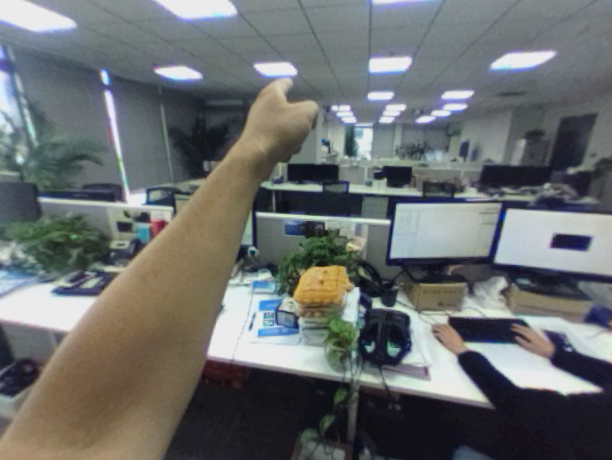

(762,)


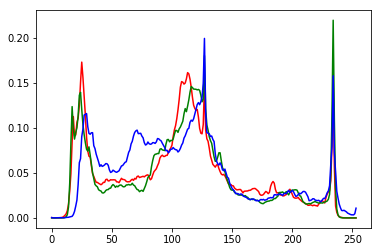

In [86]:
def hist(img, n_bin, exp_rat=0.2):
    from sklearn import preprocessing
    hs = []
    for i in range(3):
        h = np.histogram(((img[...,i]+1)*n_bin).round(), np.arange(n_bin*2+1))[0].astype(np.float32)
        h_sum = h.copy()
        h_sum[1:] += h[:-1] * exp_rat
        h_sum[:-1] += h[1:] * exp_rat
        # h_sum = (h_sum-np.mean(h_sum))/np.std(h_sum)
        h_sum = preprocessing.normalize(h_sum.reshape(1, -1), norm='l2').reshape(-1)
        hs.append(h_sum)
    return np.hstack(hs)

import matplotlib.pyplot as plt

from IPython.display import display

im = read_image('data/DeepQ-Vivepaper/data/air/img/img_00100.png')
im = Image.open('data/DeepQ-Vivepaper/data/air/img/img_00100.png').convert('RGB')
# im = Image.open('data/DeepQ-Synth-Hand-01//data/s000/img/img_00004987.png').convert('RGB')
im = np.array(im)/255*2-1

h = hist(im, 127)
display(Image.fromarray( ((im+1)*127.5).astype('uint8')))
print(h.shape)

plt.plot(h[:254], 'r')
plt.plot(h[254:508], 'g')
plt.plot(h[508:], 'b')


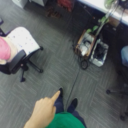

In [4]:
img = read_image('data/DeepQ-Vivepaper/data/air/img/img_00113.png')
showX(np.expand_dims(img, 0))

In [7]:
def hist(img, n_bin, exp_rat=0.3):
    from sklearn import preprocessing
    hs = []
    for i in range(3):
        h = np.histogram(((img[...,i]+1)*n_bin).round(), np.arange(n_bin*2+1))[0].astype(np.float32)
        h_sum = h.copy()
        h_sum[1:] += h[:-1] * exp_rat
        h_sum[:-1] += h[1:] * exp_rat
        # h_sum = (h_sum-np.mean(h_sum))/np.std(h_sum)
        h_sum = preprocessing.normalize(h_sum.reshape(1, -1), norm='l2').reshape(-1)
        hs.append(h_sum)
    return np.hstack(hs)
hist(img, 4)

array([0.13517524, 0.4230732 , 0.50273216, 0.6203139 , 0.35667843,
       0.12434281, 0.09271134, 0.1180331 , 0.09771422, 0.3935896 ,
       0.4525401 , 0.5934253 , 0.47377592, 0.18875773, 0.10439412,
       0.08718831, 0.0725587 , 0.32606104, 0.5004764 , 0.6501425 ,
       0.4203425 , 0.16279298, 0.0808114 , 0.07441512], dtype=float32)

In [58]:
from glob import glob
ps = glob('data/DeepQ-Vivepaper/data/air/img/*.png')
imgs = [read_image('data/DeepQ-Vivepaper/data/air/img/img_%s.png'%s) for s in ['00113', '00123', '00201', '00001']]
hs = [hist(img, 6) for img in imgs]
hss = np.stack(hs)

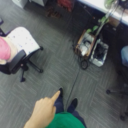

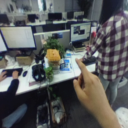

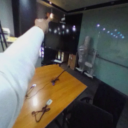

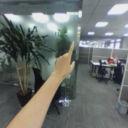

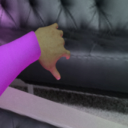

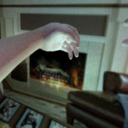

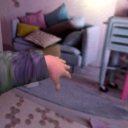

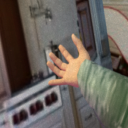

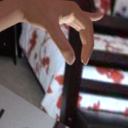

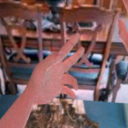

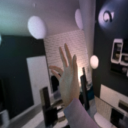

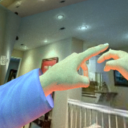

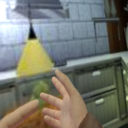

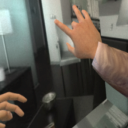

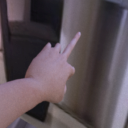

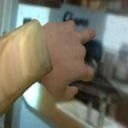

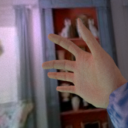

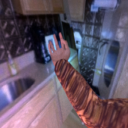

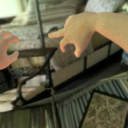

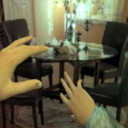

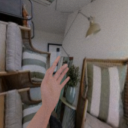

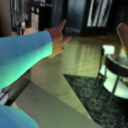

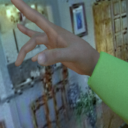

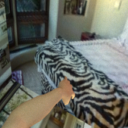

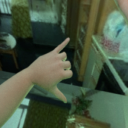

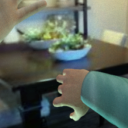

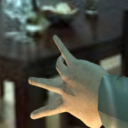

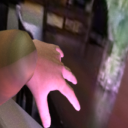

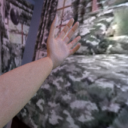

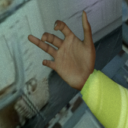

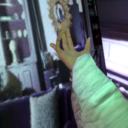

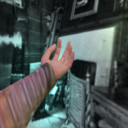

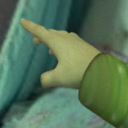

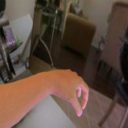

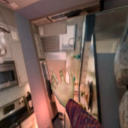

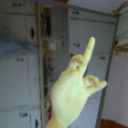

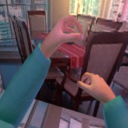

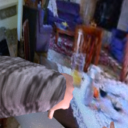

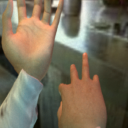

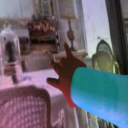

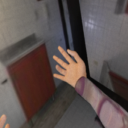

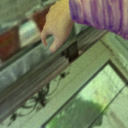

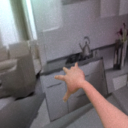

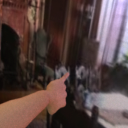

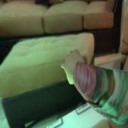

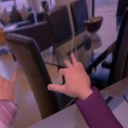

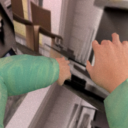

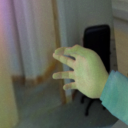

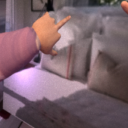

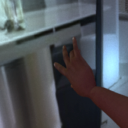

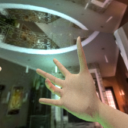

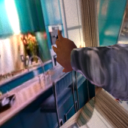

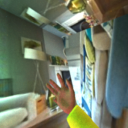

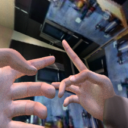

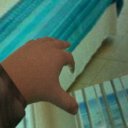

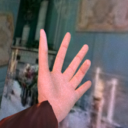

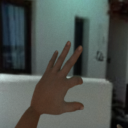

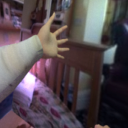

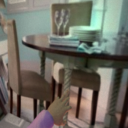

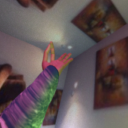

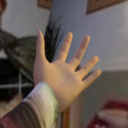

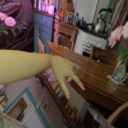

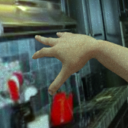

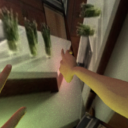

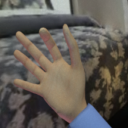

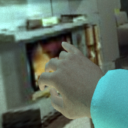

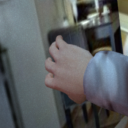

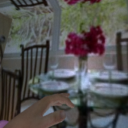

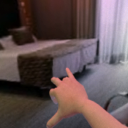

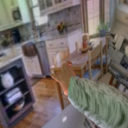

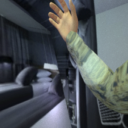

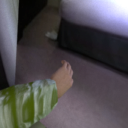

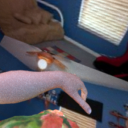

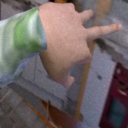

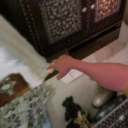

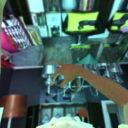

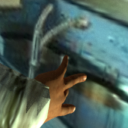

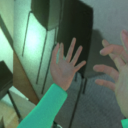

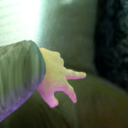

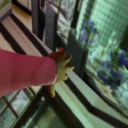

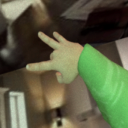

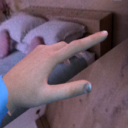

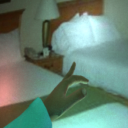

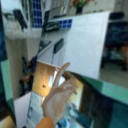

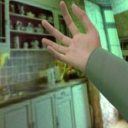

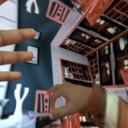

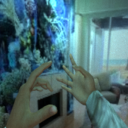

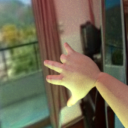

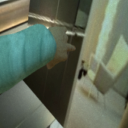

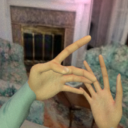

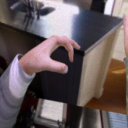

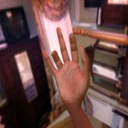

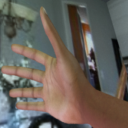

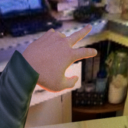

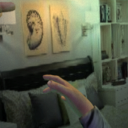

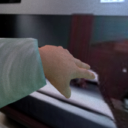

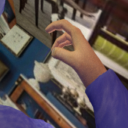

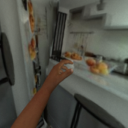

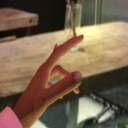

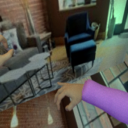

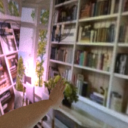

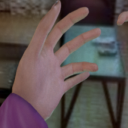

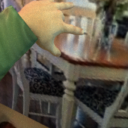

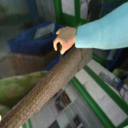

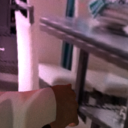

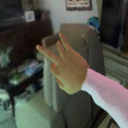

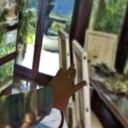

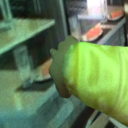

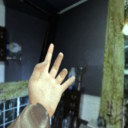

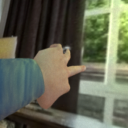

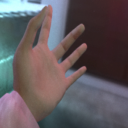

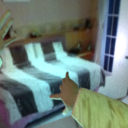

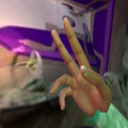

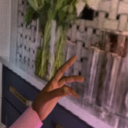

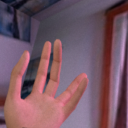

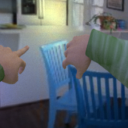

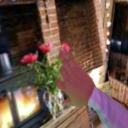

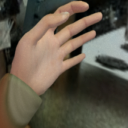

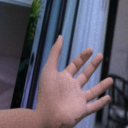

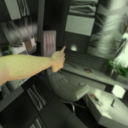

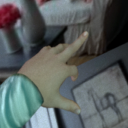

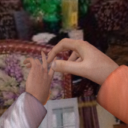

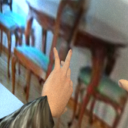

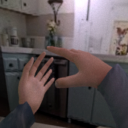

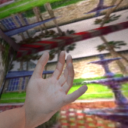

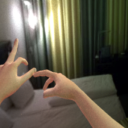

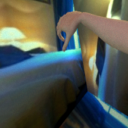

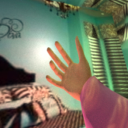

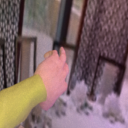

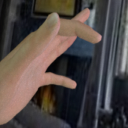

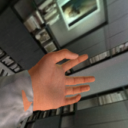

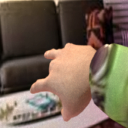

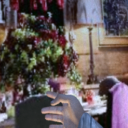

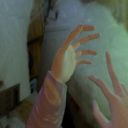

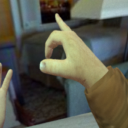

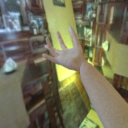

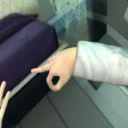

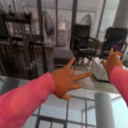

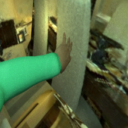

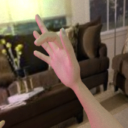

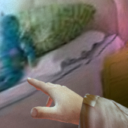

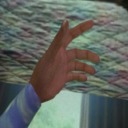

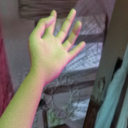

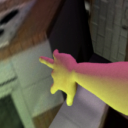

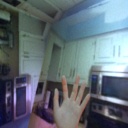

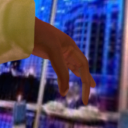

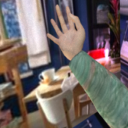

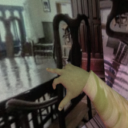

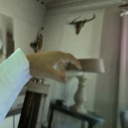

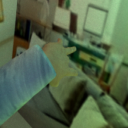

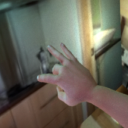

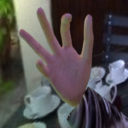

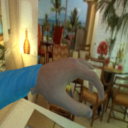

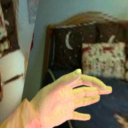

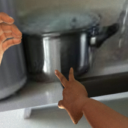

In [61]:
from glob import glob
ps = glob('data/DeepQ-Synth-Hand-01/data/s000/img/*.png')
imgs2 = [read_image(p) for p in ps]
hs2 = [hist(img, 6, 0.1) for img in imgs2]
hss2 = np.stack(hs2)
cor = np.dot(hss, hss2.T).max(axis=0)
for i in imgs:
    showX(i)
for i, c in enumerate(cor):
    if c>2.85:
        showX(imgs2[i])

In [55]:
# help(np.histogramdd)
i = imgs[0]
i = i.reshape(-1, 3)
i = (i+1) * 3
np.histogramdd(imgs[0].reshape(-1, 3), bins=(5, 5, 5))

(array([[[3.815e+03, 1.090e+02, 0.000e+00, 0.000e+00, 0.000e+00],
         [1.400e+01, 6.000e+01, 0.000e+00, 0.000e+00, 0.000e+00],
         [0.000e+00, 3.730e+02, 0.000e+00, 0.000e+00, 0.000e+00],
         [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
         [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]],
 
        [[6.520e+02, 5.200e+01, 0.000e+00, 0.000e+00, 0.000e+00],
         [3.500e+02, 4.153e+03, 4.200e+01, 0.000e+00, 0.000e+00],
         [0.000e+00, 3.920e+02, 4.100e+01, 0.000e+00, 0.000e+00],
         [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
         [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]],
 
        [[2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
         [3.000e+00, 8.500e+01, 1.000e+01, 0.000e+00, 0.000e+00],
         [0.000e+00, 1.167e+03, 2.753e+03, 2.700e+01, 0.000e+00],
         [0.000e+00, 0.000e+00, 9.300e+01, 8.500e+01, 0.000e+00],
         [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]],
 
 

In [66]:
def img_retriv(path_A, path_B, n_bins=6):
    def hist(img, n_bin, exp_rat=0.2):
        from sklearn import preprocessing
        hs = []
        for i in range(3):
            h = np.histogram(((img[...,i]+1)*n_bin).round(), np.arange(n_bin*2+1))[0].astype(np.float32)
            h_sum = h.copy()
            h_sum[1:] += h[:-1] * exp_rat
            h_sum[:-1] += h[1:] * exp_rat
            # h_sum = (h_sum-np.mean(h_sum))/np.std(h_sum)
            h_sum = preprocessing.normalize(h_sum.reshape(1, -1), norm='l2').reshape(-1)
            hs.append(h_sum)
        return np.hstack(hs)
    from glob import glob
    from random import sample
    ps = sample(glob(path_A), 20)
    imgs = [read_image(p) for p in ps]
    hs = np.stack([hist(img, n_bins) for img in imgs])

    ps = glob(path_B)
    imgs = [read_image(p) for p in ps]
    hs2 = np.stack([hist(img, n_bins) for img in imgs])
    
    cor = np.dot(hs, hs2.T).max(axis=0)
    pathes = []
    for i, c in enumerate(cor):
        if c>2.85:
            pathes.append(ps[i])
    return pathes
ps = img_retriv('data/DeepQ-Vivepaper/data/air/img/*.png', 'data/DeepQ-Synth-Hand-01/data/s000/img/img_00001*.png')
len(ps)

51

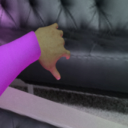

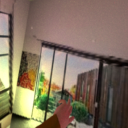

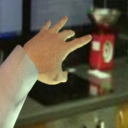

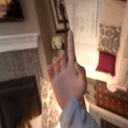

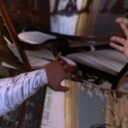

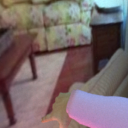

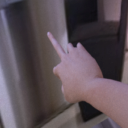

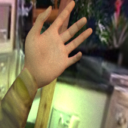

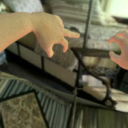

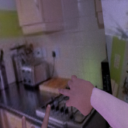

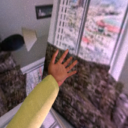

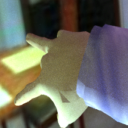

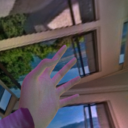

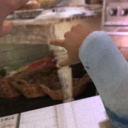

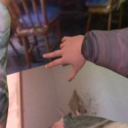

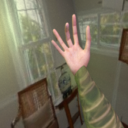

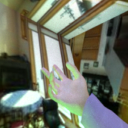

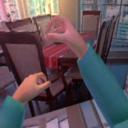

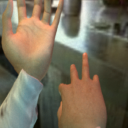

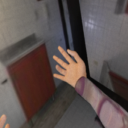

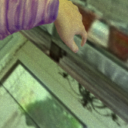

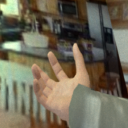

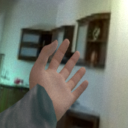

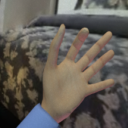

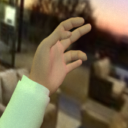

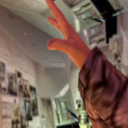

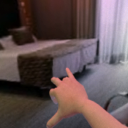

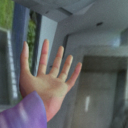

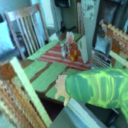

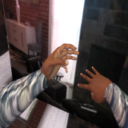

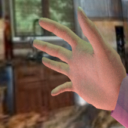

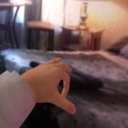

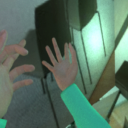

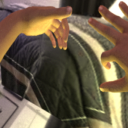

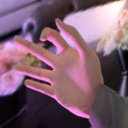

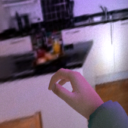

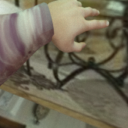

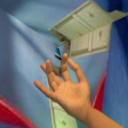

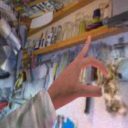

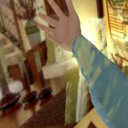

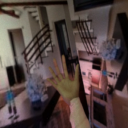

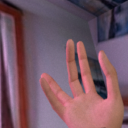

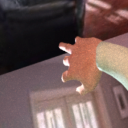

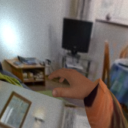

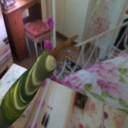

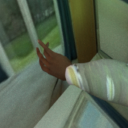

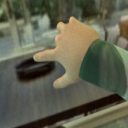

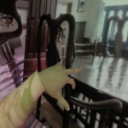

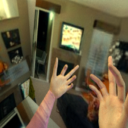

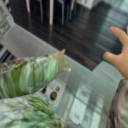

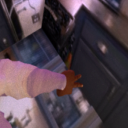

In [67]:
imgs = [read_image(p) for p in ps]
for img in imgs:
    showX(img)